# Inspired by these Sources
1. https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
2. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
3. https://rare-technologies.com/what-is-topic-coherence/
4. https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df
* https://radimrehurek.com/gensim/tut1.html

# LDA (blei 2003)
* http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

# 1. Preprocessing 

In [2]:
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

stop_words = gensim.parsing.preprocessing.STOPWORDS 

def preprocess_reviews(text):
    processed = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words  and len(token) > 3 and is_ascii(token) == True:
            #lemmatize
            processed.append(PorterStemmer().stem(WordNetLemmatizer().lemmatize(token, pos='v')))
    return processed

In [3]:
df0 = pd.read_csv('helpfulness_reviews_worst_apps.csv')
df1 = pd.read_csv('newest_reviews_worst_apps.csv')
df2 = pd.read_csv('ratings_reviews_worst_apps.csv')
df3 = pd.read_csv('2019-03-03_helpfulness_reviews_worst_apps.csv')
df4 = pd.read_csv('2019-03-03_newest_reviews_worst_apps.csv')
df5 = pd.read_csv('2019-03-03_rating_reviews_worst_apps.csv')
df6 = pd.read_csv('2019-03-09_helpfulness_reviews_worst_apps.csv')
df7 = pd.read_csv('2019-03-09_newest_reviews_worst_apps.csv')
df8 = pd.read_csv('2019-03-09_rating_reviews_worst_apps.csv')
df9 = pd.read_csv('2019-03-24_helpfulness_reviews_worst_apps.csv')
df10 = pd.read_csv('2019-03-24_newest_reviews_worst_apps.csv')
df11 = pd.read_csv('2019-03-24_rating_reviews_worst_apps.csv')

frames = [df0, df1, df2,df3,df4,df5,df6, df7,df8,df9,df10]
df = pd.concat(frames, sort =True)
df = df.reset_index(inplace = False, drop = True)
df = df.drop_duplicates(['appTitle','date', 'score', 'text'],keep= 'last')
# Drop NA's
df = df.dropna(subset=['text'])

import datetime 
df['datetime'] = pd.to_datetime(df['date'])
df['year']  = [i.year for i in df['datetime']]
df = df.drop_duplicates(['text', 'appTitle', 'year'], keep= 'last')
#df[df[['text', 'appTitle', 'year']].duplicated() == True].sort_values('text'))

import numpy as np
np.random.seed(1995)
df = df.reindex(np.random.permutation(df.index))
df =df.reset_index(drop=True)
length_check  = [len(i) for i in df['text']]


In [4]:
framestest = [df0, df1, df2,df3,df4,df5,df6, df7,df8,df9,df10,df11]
testing = pd.concat(framestest)
testing['appTitle'].value_counts()

Power Battery - Battery Life Saver & Health Test      53760
Battery Doctor-Battery Life Saver & Battery Cooler    53760
WeChat                                                53760
Peel Universal Smart TV Remote Control                53759
LINE: Free Calls & Messages                           53720
Microsoft Outlook                                     53720
Netflix                                               53719
WhatsApp Messenger                                    53716
Snapchat                                              53714
Google Assistant                                      53680
Updates for Samsung - Android Update Versions         53680
Peel Smart Remote TV Guide                            53680
DU Battery Saver - Battery Charger & Battery Life     53680
Android Accessibility Suite                           53679
Messenger – Text and Video Chat for Free              53676
Google                                                53671
Facebook                                

In [5]:
len(testing)

1234836

In [6]:
# None are duplicated
# df[df[['appTitle','date', 'score', 'text']].duplicated()]

# Review distribution by year

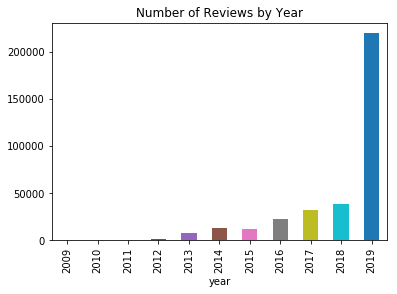

In [7]:
df.groupby('year').count()['text'].plot.bar()
plt.rcParams["figure.figsize"] = (9,6)
plt.title("Number of Reviews by Year")
plt.show()

In [8]:
# 51 characters on average 
print("mean number of characters in a user review: ", np.mean(length_check))
# 
print("min number of chracters: ", min(length_check))
print("max number of character: ", max(length_check))

mean number of characters in a user review:  61.93634425731624
min number of chracters:  1
max number of character:  1979


# Document Length Distribution 
* We see that most of the reviews are less than 250 chaacters 
* usually a senetence is at least 10 words but less than 20 words 
* and on average the words we use is about 4.8 characters 
* so probably want to remove reviews that are less than 48 characters in length
* But I phyiscally checked quite a few of the documents and believed that if we remove those shorter than a sentence topics we might be removing important information and applying bias
* So lets just remove the extremes of document length less than 10 characters



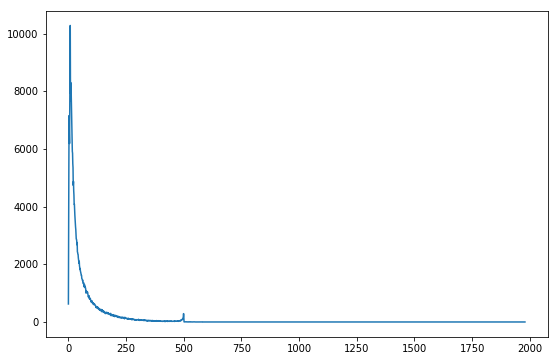

In [9]:
testdataframe = df
testdataframe['review_length'] = length_check
testdataframe['review_length'].value_counts().sort_index().plot()
#lets remove the 3 character reviews 
plt.show()


In [10]:
lessthan10 = testdataframe[testdataframe['review_length'] < 10].index.values
df = df.drop(df.index[lessthan10])

# add another column to the dataframe as the processed reviews
df['processed'] = df['text'].map(preprocess_reviews)

df = df.dropna(subset=['processed'])

# lets look at some extremely long documents 
* This is quite interesting since all the long reviews are coming from Google Assistant, Battery Doctor, Google Play Music, Hangouts, and Peel smart remote TV guide. We can then assume that the long reviews in the other apps are just outliers 

In [11]:
long_review = testdataframe[testdataframe['review_length'] > 600]
long_review.groupby('appTitle').count()

,date,score,text,userName,datetime,year,review_length
appTitle,,,,,,,
Amazon Shopping,5,5,5,2,5,5,5
Android Accessibility Suite,4,4,4,4,4,4,4
Battery Doctor-Battery Life Saver & Battery Cooler,30,30,30,25,30,30,30
DU Battery Saver - Battery Charger & Battery Life,4,4,4,4,4,4,4
Facebook,3,3,3,2,3,3,3
Google,1,1,1,0,1,1,1
Google Assistant,46,46,46,39,46,46,46
Google Duo - High Quality Video Calls,2,2,2,1,2,2,2
Google Play Music,19,19,19,17,19,19,19


# Take a look at some of the reviews in those particular apps
* We see that on average these long reviews are probably negative. 
* I looked at a few of these reviews and indeed most of them are complaints
* We can sort of conclude that Peel Smart remote, Battery Doctor, Peel Smart remote has problems 
* People don't write long reviews for no reason. 


In [12]:
print("Mean Score for reviews longer than 1000 characters for Google Assistant", long_review[long_review['appTitle'] == 'Google Assistant']['score'].mean())
print("Mean Score for reviews longer than 1000 characters for Peel Smart Remote TV Guide", long_review[long_review['appTitle'] == 'Peel Smart Remote TV Guide']['score'].mean())
print("Mean Score for reviews longer than 1000 characters for Power Battery", long_review[long_review['appTitle'] == 'Power Battery - Battery Life Saver & Health Test']['score'].mean())
print("Mean Score for reviews longer than 1000 characters for Google Play Music", long_review[long_review['appTitle'] == 'Google Play Music']['score'].mean())
print("Mean Score for reviews longer than 1000 characters for Battery Doctor", long_review[long_review['appTitle'] == 'Battery Doctor-Battery Life Saver & Battery Cooler']['score'].mean())
print("Mean Score for reviews longer than 1000 characters for Hangouts", long_review[long_review['appTitle'] == 'Hangouts']['score'].mean())

Mean Score for reviews longer than 1000 characters for Google Assistant 2.8260869565217392
Mean Score for reviews longer than 1000 characters for Peel Smart Remote TV Guide 1.75
Mean Score for reviews longer than 1000 characters for Power Battery 1.8
Mean Score for reviews longer than 1000 characters for Google Play Music 3.0526315789473686
Mean Score for reviews longer than 1000 characters for Battery Doctor 2.1333333333333333
Mean Score for reviews longer than 1000 characters for Hangouts 2.7222222222222223


In [13]:
df = df[df['processed'].map(lambda d: len(d)) > 1]
# We take only the rows that have tokenized docuemnt greate 
df =df.reset_index(drop=True)
len(df)

240874

# What problems are mentioned in these long reviews?


In [14]:
testdataframe = df
length_check = [len(i) for i in df['text']]
testdataframe['review_length'] = length_check

### Peel Smart Remote TV Guide	
- ads come up without opening the app, pop-up adds are very annoying 
- popping notifications 
- Uninstall issues, cant uninstall and if you uninstall it pops up again

### Google Assistant
- Problems are different and individualized. No general problem

### Google Play Music
- Problems are different and individualized. No general problem

### Hangouts
- Problems are different and individualized. No general problem

### Battery Doctor-Battery Life Saver & Battery Cooler
- set specific lower and upper limit for charging (Setting an alarm) 
- Advertisements are annoying 
- background apps running
- pop-up for permission (cheetah mobile involved in fraud investigation)
- slowed down phone

In [15]:
df.to_csv("user-review.csv", index = False)

# Specific Cleaning through observation of results

In [16]:
# remove words rows that contain words like ffff xxxx aaaa etc 

count = 0
removed_index = []
for i in df['processed']:
    count +=1
    for t in range(0, len(i)):
        if 'fff' in i[t]:
            removed_index.append(count-1)
            
new_removed_index = list(set(removed_index))
df = df.drop(df.index[new_removed_index])
df =df.reset_index(drop=True)

count = 0
removed_index2 = []
for i in df['processed']:
    count +=1
    for t in range(0, len(i)):
        if 'xxxxx' in i[t]:
            removed_index2.append(count-1)
            
new_removed_index2 = list(set(removed_index2))
df = df.drop(df.index[new_removed_index2])
df =df.reset_index(drop=True)
# SHOULD PROBABLY find a general way to remove the user-reviews that are weirdly typed with duplicating letters 
# xxx, aaa, dddd, etc
count = 0 
removed_index3 = [] 
for i in df['processed']:
    count +=1
    if len(i) ==1:
        removed_index3.append(count-1)
df = df.drop(df.index[removed_index3])
df =df.reset_index(drop=True)

# remove rows that have less than 16 characters 
# I physically looked through a lot of these and many of the shorter length documents contain uninformative text
length_check2 = [len(i) for i in df['text']]
testdataframe2 = df
testdataframe2['review_length'] = length_check2
lessthan16 = testdataframe2[testdataframe2['review_length'] <= 16].index.values
df = df.drop(df.index[lessthan16])
df =df.reset_index(drop=True)

processed_length = [len(i) for i in df['processed']]
testdataframe3 = df
between17and30 = testdataframe3[(testdataframe3['review_length'] > 16) & (testdataframe3['review_length'] < 30)]['review_length'].index.values
between17and30tokenlength = [len(i) for i in df[df.index.isin(between17and30)]['processed']]

cleanfor17to30length = df[df.index.isin(between17and30)]

cleanfor17to30length['length'] = between17and30tokenlength 

# we might want to filter out the ones that have only good and best in it 
# We have too many short documents that only contain things like good best awesome 
# this made our nmf really skewed towards those words and producing weird topics 
uselesswords =[]
for i in cleanfor17to30length[cleanfor17to30length['length'] <=3]['processed'].index.values:
    if (cleanfor17to30length['processed'][i][0] in ['excel','amaz','great','best', 'awesom', 'good', 'nice', 'love', 'like', 'cool']) & (cleanfor17to30length['processed'][i][1] in ['excel','amaz','great','best', 'awesom', 'good','nice', 'love', 'like','cool']) :
        uselesswords.append(i)


#df[df.index.isin(uselesswords)]
# lets drop this 
df = df.drop(df.index[uselesswords])

df =df.reset_index(drop=True)

/Users/chi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# of we have 4460 documents that only contain useless words that we found through the results of NMF
len(uselesswords)

4460

# Review Distribution

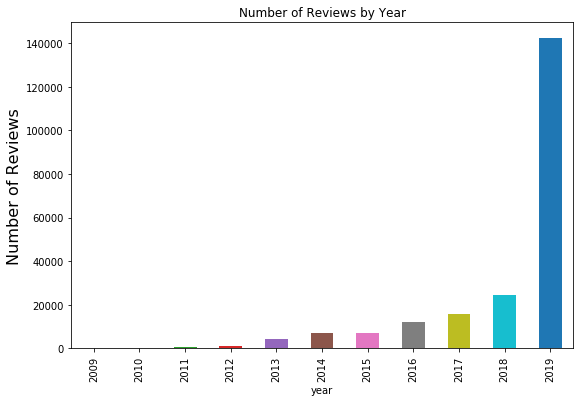

In [18]:
df.groupby('year').count()['text'].plot.bar()
plt.rcParams["figure.figsize"] = (9,6)
plt.title("Number of Reviews by Year")
plt.ylabel('Number of Reviews', fontsize=16)
plt.show()

# Review Length

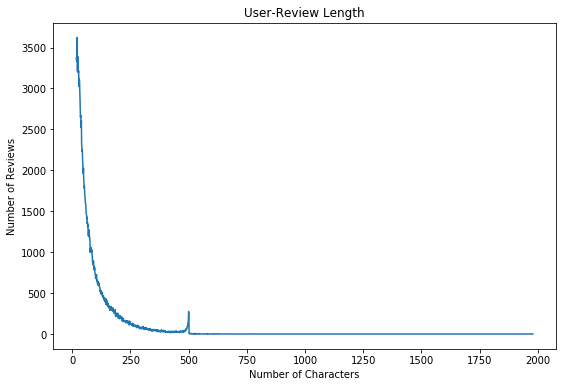

In [19]:
testdataframe = df
length_check = [len(i) for i in df['text']]
testdataframe['review_length'] = length_check
testdataframe['review_length'].value_counts().sort_index().plot()
#lets remove the 3 character reviews 
plt.title("User-Review Length")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Reviews")
plt.show()

# Topic Modelling Methods used
-	Methods used: LDA gensim using `ldamulticore` doesnt give great results
-	tested on bigram/trigram corpus and without bigram/trigram corpus both results were not great coherence scores were much lower than LDA Mallet
-	Also used LDA with TFIDF and coherence scores were the lowest of all methods
-	NMF was used but the highly associated user-reviews to the topics contained mostly words that may score high in a certain topic such as excellent, good, best, love. In my opnion, this doesn’t really make sense, which is why PCA might not work as well. 


### Seperating high and low scores
* A score of three is neutral and low scores is less than 3 and high score is higher than 3
* The majority of users do not download an app with an average star-rating of less than three 

In [21]:
high = df[df['score'] >3]
low = df[df['score'] < 3]
neutral = df[df['score'] == 3]

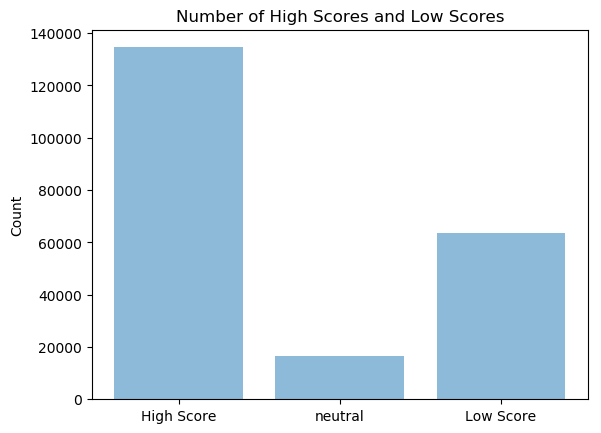

In [22]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
scores = ('High Score', 'neutral','Low Score')
y_pos = np.arange(len(scores))
numscores = [len(high),len(neutral),len(low)]
 
plt.bar(scores, numscores, align='center', alpha=0.5)
plt.xticks(y_pos, scores)
plt.ylabel('Count')
plt.title('Number of High Scores and Low Scores')
plt.show()

# Topic Modelling by year 
* We will use LDA MALLET for topic modelling on the different years from 2016 to 2019

In [23]:
# Lets do 2019 
year1 = df[df['year']==2019]
len(year1)

142415

# Split data to high and low score and ignore neutral for now 

In [24]:
high = year1[year1['score']>3]
low = year1[year1['score']<3]

low =low.reset_index(drop=True)
high = high.reset_index(drop=True)

## LDA with bigrams and trigrams 

In [25]:
bigram_high = gensim.models.phrases.Phraser(gensim.models.Phrases(high['processed'].tolist(),
                                                                     min_count=5,
                                                                     threshold=100))
#min_count = 5 => appearing at least 5 times 
trigram_high = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_high[high['processed'].tolist()],
                                                                      threshold=100))
bigram_low = gensim.models.phrases.Phraser(gensim.models.Phrases(low['processed'],
                                                                    min_count=5, 
                                                                    threshold=100))

trigram_low = gensim.models.phrases.Phraser(gensim.models.Phrases(gensim.models.Phrases(bigram_low[low['processed'].tolist()],
                                                                      threshold=100)[low['processed']],
                                                                     threshold=100))

bigrams_high = [bigram_high[sentence] for sentence in high['processed'].tolist()]
trigrams_high = [trigram_high[bigram_high[sentence]] for sentence in high['processed'].tolist()]

bigrams_low = [bigram_low[sentence] for sentence in low['processed'].tolist()]
trigrams_low = [trigram_low[bigram_low[sentence]] for sentence in low['processed'].tolist()]


# By using the bigram trigram we see that there are words that are originally separated like user friendly is now changed to user_friendly 

* "user" "friendly" => "user_friendly
* "search" "engine" => "search_engine" 
* "night" "mode" => "night_mode"
* "teen" "wolf" => "teen_wolf"
* 'highli" "recommend" => "highli_recommend"
* "mind" "blown" => "mind_blow"

## Creating the corpus and dictionary

In [26]:
import gensim
import gensim.corpora as corpora

dic1 = corpora.Dictionary(trigrams_low)
# keep only the terms that appear more than 3 times and only the top 10000
dic1.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document1 =trigrams_low

# Should we only keep the top 10000 when the length of the dictionary is 18000?
# id2word1.filter_extremes(keep_n = 10000)

corpus_low = [dic1.doc2bow(text) for text in document1]

dic2 = corpora.Dictionary(trigrams_high)
dic2.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 20000)
document2 =trigrams_high

corpus_high = [dic2.doc2bow(text) for text in document2]

In [27]:
# after filtering out the extremes we have the below lengths of the dictionary
print("length of dic low: ", len(dic1), "length of dic high ", len(dic2))

length of dic low:  10000 length of dic high  20000


### Run LDA Mallet
* Best Workign model so far based on the coherence scores

In [28]:
import os
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
low_coherence = []
high_coherence = []

# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]
for i in topics:
    mallet_low = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low, 
                                              num_topics=i,
                                              id2word=dic1,
                                              workers = 4,random_seed = 2013)
    coherence_mallet_low = CoherenceModel(model=mallet_low, texts=document1, dictionary=dic1, coherence='c_v').get_coherence()
    low_coherence.append(coherence_mallet_low)
    
    mallet_high = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high, 
                                              num_topics=i,
                                              id2word=dic2, 
                                              workers = 4, random_seed = 2013)
    coherence_mallet_high = CoherenceModel(model=mallet_high, texts=document2, dictionary=dic2, coherence='c_v').get_coherence()
    high_coherence.append(coherence_mallet_high)

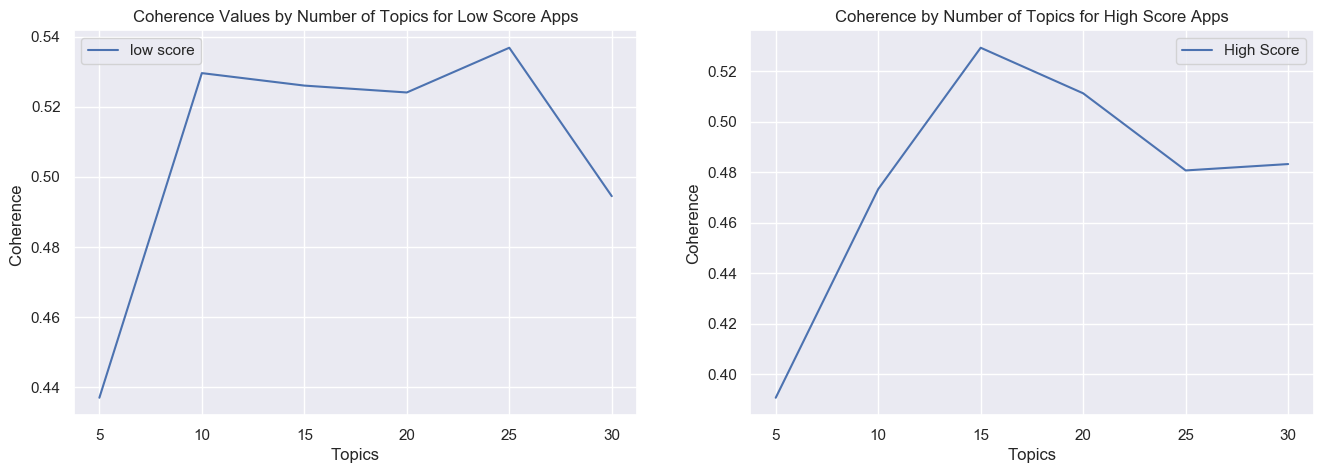

In [29]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import seaborn as sns; sns.set()

palette = dict(zip([1,2],sns.color_palette("nipy_spectral_r", 4)))

fig, (ax1, ax2)= plt.subplots(ncols = 2,figsize=(16, 5))
ax1 = sns.lineplot(topics ,low_coherence, palette = palette,ax=ax1, label = "low score")

ax1.set(xlabel ='Topics')
ax1.set(ylabel = 'Coherence ')
ax1.set_title('Coherence Values by Number of Topics for Low Score Apps')
leg =ax1.legend()
ax2 = sns.lineplot(topics, high_coherence, ax = ax2, label = "High Score")

ax2.set(xlabel ='Topics')
ax2.set(ylabel = 'Coherence')
ax2.set_title("Coherence by Number of Topics for High Score Apps")

plt.show()

In [30]:
mallet_low = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low, 
                                              num_topics=20,
                                              id2word=dic1,
                                              workers = 4,random_seed = 2013)
    
mallet_high = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high, 
                                              num_topics=15,
                                              id2word=dic2, 
                                              workers = 4, random_seed = 2013)

# LDA Mallet Topics of High Score

In [31]:
for idx, topic in mallet_high.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.215*"video" + 0.142*"qualiti" + 0.089*"call" + 0.050*"clear" + 0.048*"voic" + 0.047*"pictur" + 0.039*"excel" + 0.036*"sound" + 0.035*"good" + 0.026*"audio" 

Topic: 1 
Words: 0.165*"time" + 0.154*"work" + 0.027*"stop" + 0.025*"long" + 0.023*"littl" + 0.023*"start" + 0.022*"tri" + 0.021*"instal" + 0.018*"fine" + 0.016*"year" 

Topic: 2 
Words: 0.283*"great" + 0.047*"servic" + 0.043*"easi" + 0.038*"amazon" + 0.035*"fast" + 0.032*"free" + 0.026*"shop" + 0.026*"recommend" + 0.021*"excel" + 0.016*"custom" 

Topic: 3 
Words: 0.154*"friend" + 0.145*"love" + 0.074*"famili" + 0.058*"talk" + 0.052*"amaz" + 0.046*"connect" + 0.043*"commun" + 0.037*"filter" + 0.029*"text" + 0.026*"face" 

Topic: 4 
Words: 0.083*"peopl" + 0.064*"thing" + 0.060*"chat" + 0.039*"world" + 0.038*"person" + 0.038*"group" + 0.023*"share" + 0.022*"differ" + 0.021*"inform" + 0.019*"post" 

Topic: 5 
Words: 0.240*"good" + 0.157*"nice" + 0.086*"work" + 0.084*"app" + 0.049*"great" + 0.033*"improv" + 0.030*"p

# LDA Mallet Topic Low Score

In [32]:
for idx, topic in mallet_low.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.098*"peopl" + 0.073*"option" + 0.066*"remov" + 0.065*"featur" + 0.035*"group" + 0.029*"thing" + 0.021*"review" + 0.018*"hangout" + 0.018*"talk" + 0.018*"bring" 

Topic: 1 
Words: 0.095*"version" + 0.090*"android" + 0.069*"snapchat" + 0.041*"samsung" + 0.040*"camera" + 0.036*"qualiti" + 0.032*"poor" + 0.028*"user" + 0.026*"galaxi" + 0.024*"filter" 

Topic: 2 
Words: 0.182*"messag" + 0.145*"video" + 0.139*"send" + 0.044*"receiv" + 0.043*"call" + 0.042*"voic" + 0.036*"text" + 0.034*"sound" + 0.021*"type" + 0.017*"hear" 

Topic: 3 
Words: 0.108*"delet" + 0.093*"dont" + 0.061*"contact" + 0.036*"access" + 0.035*"support" + 0.032*"abl" + 0.024*"person" + 0.024*"automat" + 0.021*"year" + 0.020*"fail" 

Topic: 4 
Words: 0.042*"servic" + 0.038*"amazon" + 0.037*"month" + 0.034*"custom" + 0.028*"money" + 0.026*"order" + 0.020*"free" + 0.020*"item" + 0.017*"pay" + 0.017*"compani" 

Topic: 5 
Words: 0.103*"chang" + 0.072*"hate" + 0.068*"suck" + 0.048*"make" + 0.039*"horribl" + 0.0

# Since LDA is under an unsupervised context lets look at what each topic means by identfiying user-reviews associated with the topics and physically read the user-reviews to understand the topics

# Low 

In [41]:
def topic_text(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords_low = topic_text(ldamodel=mallet_low, corpus=corpus_low, texts=low['text'])
df_dominant_topic_low = df_topic_sents_keywords_low.reset_index()
df_dominant_topic_low.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
sent_topics_sorteddf_mallet_low = pd.DataFrame()

sent_topics_outdf_grpd_low = df_topic_sents_keywords_low.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_low:
    sent_topics_sorteddf_mallet_low = pd.concat([sent_topics_sorteddf_mallet_low, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_low.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_low.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [42]:
sent_topics_sorteddf_mallet_low

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2372,"peopl, option, remov, featur, group, thing, re...",I don't know why admin is a feature added on m...
1,0.0,0.2215,"peopl, option, remov, featur, group, thing, re...",Needs more privacy. We were all forced to down...
2,0.0,0.2159,"peopl, option, remov, featur, group, thing, re...","It's a boring app now..I used to use this app,..."
3,0.0,0.2121,"peopl, option, remov, featur, group, thing, re...","""I Want You Back"" - Google has told most power..."
4,0.0,0.2034,"peopl, option, remov, featur, group, thing, re...",If you want to talk to real bots you can use t...
5,1.0,0.3341,"version, android, snapchat, samsung, camera, q...",Ganz im Ernst was soll sowas mit anrufen geht ...
6,1.0,0.3292,"version, android, snapchat, samsung, camera, q...","Die App wäre an sich sehr schön, aber sie stür..."
7,1.0,0.3153,"version, android, snapchat, samsung, camera, q...",Habe ungelogen vllt 3 Filter wenn es rauf komm...
8,1.0,0.2954,"version, android, snapchat, samsung, camera, q...",Ich habe in peru gewohnt dort habe ich auf Net...
9,1.0,0.2778,"version, android, snapchat, samsung, camera, q...",Die app ist komplett abgestürzt. Nach dem letz...



|Topic|words|description|
|---|---|---|
Topic: 1| notif, email, contact, sound, remov, support, miss, repli, set, mail|email/ email notifications (Microsoft Outlook)|
Topic: 2| phone, uninstal, instal, delet, hate, messeng, emoji, dark_mode, space, permiss|install or unistall the app based on some reasons|
Topic: 3| amazon, servic, custom, month, money, order, free, item, compani, inform|Amazon, Amzon prime delivery issues|
Topic: 4| chang, good, featur, app, year, differ, thing, talk, feel, basic|changes and updates|
Topic: 5| work, stop, tri, wont, properli, fine, great, doesnt, reinstal, day|functionality (is it working properly?)|
Topic: 6| phone, screen, annoy, add, turn, pop, disabl, lock, assist, uninstal|ads/notifications/pop ups/lock screen concerns|
Topic: 7| facebook, post, photo, friend, peopl, page, group, share, comment, delet|Facebook| 
Topic: 8| account, tri, number, wechat, sign, friend, block, login, reason, password|Account issues(especially verification issue)(Wechat)|
Topic: 9| updat, version, option, save, anymor, stori, longer, snap, remov, view|Updates app/version (Snap chat)| 
Topic: 10| messag, send, chat, connect, call, data, read, text, receiv, wifi|Instant Messaging issues (Line, Facebook, snapchat, maybe more)|
Topic: 11| android, snapchat, pictur, camera, user, qualiti, poor, snap, terribl, filter|Snapchat Camera Quality (Especially android screengrabs?)(Especially complaining about android users)|
Topic: 12| googl, show, wrong, locat, map, navig, direct, place, lose, rout|Navigation(problems) some prefer waze|
Topic: 13| problem, issu, worst, whatsapp, voic, unabl, applic, mobil, statu, respond|slightly ambiugous, mostly addressing concerns|
Topic: 14| time, load, slow, make, long, imag, frustrat, minut, hard, run|slow app takes time to load (snap, maps)|
Topic: 15| play, music, googl, song, download, listen, file, store, playlist, onlin|Music|
Topic: 16| open, video, crash, close, freez, start, everytim, constantli, caus, forc|Video issues (snapchat/netlix/facebook)|
Topic: 17| download, devic, show, watch, netflix, error, good, avail, movi, abl|netflix/movie| 
Topic: 18| updat, suck, latest, recent, wors, bug, mess, fix, ruin, happi|Update Complaints|
Topic: 19| star, search, click, button, function, list, review, give, break, type|search functionality in apps (google, amazon)| 


# High

In [39]:
df_topic_sents_keywords_high = topic_text(ldamodel=mallet_high, corpus=corpus_high, texts=high['text'])

df_dominant_topic_high = df_topic_sents_keywords_high.reset_index()
df_dominant_topic_high.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

sent_topics_sorteddf_mallet_high = pd.DataFrame()

sent_topics_outdf_grpd_high = df_topic_sents_keywords_high.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_high:
    sent_topics_sorteddf_mallet_high = pd.concat([sent_topics_sorteddf_mallet_high, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_high.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_high.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [40]:
sent_topics_sorteddf_mallet_high

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2538,"video, qualiti, call, clear, voic, pictur, exc...",Zongo Chat is fast becoming my default phone c...
1,0.0,0.2455,"video, qualiti, call, clear, voic, pictur, exc...",The quality of my video calls blow Skype and V...
2,0.0,0.2333,"video, qualiti, call, clear, voic, pictur, exc...",Overall good voice quality. The video pixelate...
3,0.0,0.2238,"video, qualiti, call, clear, voic, pictur, exc...","Very clear video picture, and the audio is so ..."
4,0.0,0.2237,"video, qualiti, call, clear, voic, pictur, exc...",Best Video Calling App EVER. I have tried so m...
5,1.0,0.3042,"time, work, stop, long, littl, start, tri, ins...","Awesome!//^^""_¥:€/ if the company during fiho ..."
6,1.0,0.3019,"time, work, stop, long, littl, start, tri, ins...",good sexual visual distrustful p divisional fi...
7,1.0,0.2683,"time, work, stop, long, littl, start, tri, ins...",what you doing anything now nikki you work tom...
8,1.0,0.2358,"time, work, stop, long, littl, start, tri, ins...",Thanks so much for all you have done so you ha...
9,1.0,0.2239,"time, work, stop, long, littl, start, tri, ins...",thanks for letting me know about the next step...


|Topic|words|description|
|---|---|---|
Topic: 1| friend, peopl, famili, talk, connect, snapchat, love, text, chat, commun |friends and family (communication/connection through apps)|
Topic: 2| love, movi, watch, show, netflix, amaz, favorit, bring, seri, season|Netlflix/movies|
Topic: 3| messag, whatsapp, option, send, chat, contact, group, delet, save, statu|Instant Messaging|
Topic: 4| video, qualiti, good, call, pictur, clear, voic, sound, excel, audio|Video/Voice Calling (Google Duo)|
Topic: 5| googl, phone, app, android, world, user, assist, batteri, facetim, iphon|Google|
Topic: 6| applic, remot, devic, amaz, thing, screen, control, peel, access, home|Remote Control (Peel) Very convenient app| 
Topic: 7| updat, facebook, mode, messeng ,dark, star, chang, hope, emoji, theme|Dark mode, (facebook/messenger)|
Topic: 8| great, easi, servic, amazon, fast, shop, free, time, onlin, custom|Amazon/Amazon Prime is great|
Topic: 9| easi, email, account, outlook, mail, mobil, work, simpl, view, import|email (How greate Outlook is)|
Topic: 10| updat, problem, version, issu, open, notif, stop, load, slow, crash|update problems|
Topic: 11| good, nice, exper, enjoy, excel, hangout, word, superb, beauti, fantast|Compliments|
Topic: 12| time, life, place, map, navig, long, live, inform, differ, abl|Navigation problems| 
Topic: 13| work, great, awesom, cool, super, perfect, happi, pretti, good, stuff|Compliments| 
Topic: 14| download, music, play, year, add, song, avail, data, list, store|Music|

# What if I did not split the data set into low scores and high scores

In [44]:
bigram_2019 = gensim.models.phrases.Phraser(gensim.models.Phrases(year1['processed'].tolist(),
                                                                     min_count=5,
                                                                     threshold=100))
#min_count = 5 => appearing at least 5 times 
trigram_2019 = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_high[year1['processed'].tolist()],
                                                                      threshold=100))

bigrams_2019 = [bigram_2019[sentence] for sentence in year1['processed'].tolist()]
trigrams_2019 = [trigram_2019[bigram_2019[sentence]] for sentence in year1['processed'].tolist()]


dic2019 = corpora.Dictionary(trigrams_2019)
dic2019.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document2019 =trigrams_2019

corpus_2019 = [dic2019.doc2bow(text) for text in document2019]


coherence = []

# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]
for i in topics:
    mallet = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_2019, 
                                              num_topics=i,
                                              id2word=dic2019,
                                              workers = 4,random_seed = 2013)
    coherence_mallet = CoherenceModel(model=mallet, texts=document2019, dictionary=dic2019, coherence='c_v').get_coherence()
    coherence.append(coherence_mallet)



In [45]:
#based on coherence score the highest is 20 topics
mallet = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_2019, 
                                              num_topics=20,
                                              id2word=dic2019,
                                              workers = 4,random_seed = 2013)

In [46]:
for idx, topic in mallet.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.205*"great" + 0.107*"nice" + 0.098*"easi" + 0.058*"awesom" + 0.056*"experi" + 0.045*"search" + 0.041*"good" + 0.031*"fast" + 0.028*"enjoy" + 0.026*"super" 

Topic: 1 
Words: 0.069*"watch" + 0.064*"netflix" + 0.063*"movi" + 0.058*"show" + 0.048*"servic" + 0.041*"amazon" + 0.027*"custom" + 0.024*"month" + 0.022*"order" + 0.021*"money" 

Topic: 2 
Words: 0.260*"love" + 0.143*"friend" + 0.051*"famili" + 0.046*"talk" + 0.038*"filter" + 0.038*"great" + 0.035*"commun" + 0.032*"amaz" + 0.029*"cool" + 0.028*"face" 

Topic: 3 
Words: 0.160*"messag" + 0.120*"send" + 0.096*"notif" + 0.061*"delet" + 0.057*"problem" + 0.034*"receiv" + 0.030*"read" + 0.029*"text" + 0.027*"check" + 0.023*"open" 

Topic: 4 
Words: 0.333*"work" + 0.079*"stop" + 0.060*"problem" + 0.053*"issu" + 0.039*"tri" + 0.033*"fine" + 0.026*"properli" + 0.025*"error" + 0.019*"doesnt" + 0.019*"start" 

Topic: 5 
Words: 0.221*"video" + 0.140*"good" + 0.111*"qualiti" + 0.082*"call" + 0.059*"voic" + 0.044*"sound" + 0.

In [47]:
df_topic_sents_keywords_2019 = topic_text(ldamodel=mallet, corpus=corpus_2019, texts=year1['text'])

df_dominant_topic_2019 = df_topic_sents_keywords_2019.reset_index()
df_dominant_topic_2019.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#df_dominant_topic
sent_topics_sorteddf_mallet_2019 = pd.DataFrame()

sent_topics_outdf_grpd_2019 = df_topic_sents_keywords_2019.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_2019:
    sent_topics_sorteddf_mallet_2019 = pd.concat([sent_topics_sorteddf_mallet_2019, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_2019.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_2019.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet_2019

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1859,"great, nice, easi, awesom, experi, search, goo...",NaN
1,0.0,0.1763,"great, nice, easi, awesom, experi, search, goo...",pretty good connection. set up was easy
2,0.0,0.1737,"great, nice, easi, awesom, experi, search, goo...",it used to be wonderful but lately it's not so...
3,0.0,0.1648,"great, nice, easi, awesom, experi, search, goo...",I think it is okay for me
4,0.0,0.1554,"great, nice, easi, awesom, experi, search, goo...",Its the greatest app ever im so happy this was...
5,1.0,0.3101,"watch, netflix, movi, show, servic, amazon, cu...",Pls remove the stupid 3G or better restriction...
6,1.0,0.2922,"watch, netflix, movi, show, servic, amazon, cu...",NaN
7,1.0,0.2812,"watch, netflix, movi, show, servic, amazon, cu...","Very clunky, trying to make a playlist is a ve..."
8,1.0,0.2770,"watch, netflix, movi, show, servic, amazon, cu...",i love to talk to my friends on it
9,1.0,0.2755,"watch, netflix, movi, show, servic, amazon, cu...",I opted to not show stories in Indonesian and ...


# 2018 Topic Analysis 

In [24]:
year2 = df[df['year']==2018]
high2 = year2[year2['score']>3]
low2 = year2[year2['score']<3]
low2 =low2.reset_index(drop=True)
high2 = high2.reset_index(drop=True)

bigram_high2 = gensim.models.phrases.Phraser(gensim.models.Phrases(high2['processed'].tolist(),
                                                                     min_count=5,
                                                                     threshold=100))
#min_count = 5 => appearing at least 5 times 
trigram_high2 = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_high2[high2['processed'].tolist()],
                                                                      threshold=100))
bigram_low2 = gensim.models.phrases.Phraser(gensim.models.Phrases(low2['processed'],
                                                                    min_count=5, 
                                                                    threshold=100))

trigram_low2 = gensim.models.phrases.Phraser(gensim.models.Phrases(gensim.models.Phrases(bigram_low2[low2['processed'].tolist()],
                                                                      threshold=100)[low2['processed']],
                                                                     threshold=100))

bigrams_high2 = [bigram_high2[sentence] for sentence in high2['processed'].tolist()]
trigrams_high2 = [trigram_high2[bigram_high2[sentence]] for sentence in high2['processed'].tolist()]

bigrams_low2 = [bigram_low2[sentence] for sentence in low2['processed'].tolist()]
trigrams_low2 = [trigram_low2[bigram_low2[sentence]] for sentence in low2['processed'].tolist()]

import gensim
import gensim.corpora as corpora

dic2018_low = corpora.Dictionary(trigrams_low2)
# keep only the terms that appear more than 3 times and only the top 10000
dic2018_low.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document2018_low =trigrams_low2

# Should we only keep the top 10000 when the length of the dictionary is 18000?
# id2word1.filter_extremes(keep_n = 10000)

corpus_low2 = [dic2018_low.doc2bow(text) for text in document2018_low]

dic2018_high = corpora.Dictionary(trigrams_high2)
dic2018_high.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 20000)
document2018_high =trigrams_high2

corpus_high2 = [dic2018_high.doc2bow(text) for text in document2018_high]


import os
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
low_coherence2018 = []
high_coherence2018 = []

# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]
for i in topics:
    mallet_low_2018 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low2, 
                                              num_topics=i,
                                              id2word=dic2018_low,
                                              workers = 4,random_seed = 2013)
    coherence_mallet_low_2018 = CoherenceModel(model=mallet_low_2018, texts=document2018_low, dictionary=dic2018_low, coherence='c_v').get_coherence()
    low_coherence2018.append(coherence_mallet_low_2018)
    
    mallet_high_2018 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high2, 
                                              num_topics=i,
                                              id2word=dic2018_high, 
                                              workers = 4, random_seed = 2013)
    coherence_mallet_high_2018 = CoherenceModel(model=mallet_high_2018, texts=document2018_high, dictionary=dic2018_high, coherence='c_v').get_coherence()
    high_coherence2018.append(coherence_mallet_high_2018)
    
    


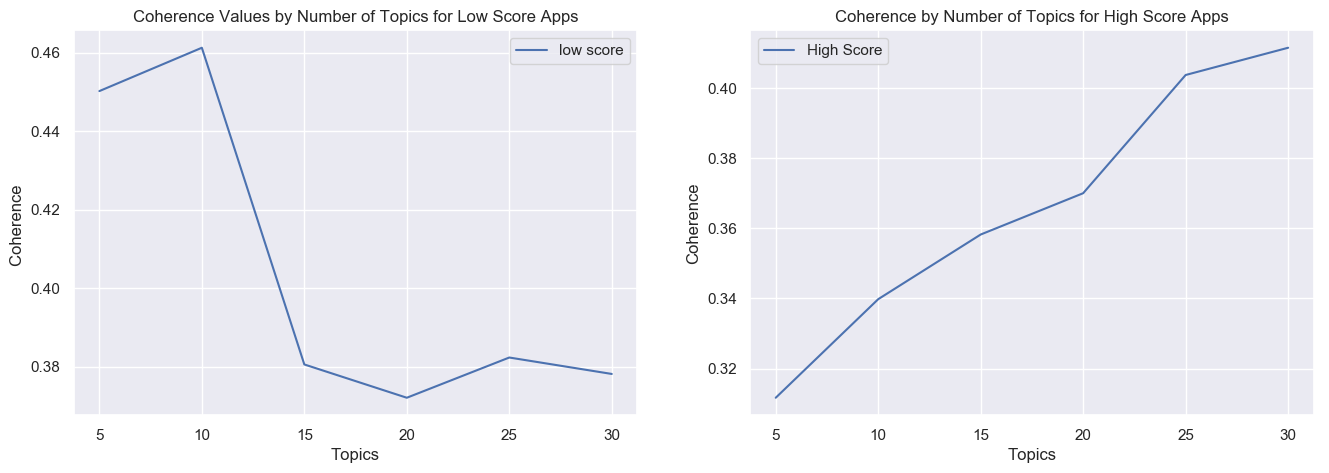

In [25]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import seaborn as sns; sns.set()

palette = dict(zip([1,2],sns.color_palette("nipy_spectral_r", 4)))

fig, (ax1, ax2)= plt.subplots(ncols = 2,figsize=(16, 5))
ax1 = sns.lineplot(topics ,low_coherence2018, palette = palette,ax=ax1, label = "low score")

ax1.set(xlabel ='Topics')
ax1.set(ylabel = 'Coherence ')
ax1.set_title('Coherence Values by Number of Topics for Low Score Apps')
leg =ax1.legend()
ax2 = sns.lineplot(topics, high_coherence2018, ax = ax2, label = "High Score")

ax2.set(xlabel ='Topics')
ax2.set(ylabel = 'Coherence')
ax2.set_title("Coherence by Number of Topics for High Score Apps")

plt.show()

In [50]:
mallet_low_2018 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low2, 
                                              num_topics=10,
                                              id2word=dic2018_low,
                                              workers = 4,random_seed = 2013)
    
mallet_high_2018 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high2, 
                                              num_topics=30,
                                              id2word=dic2018_high, 
                                              workers = 4, random_seed = 2013)

In [51]:
for idx, topic in mallet_high_2018.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.332*"time" + 0.064*"long" + 0.053*"face" + 0.028*"load" + 0.021*"run" + 0.019*"hard" + 0.016*"quickli" + 0.016*"year" + 0.014*"morn" + 0.012*"appreci" 

Topic: 1 
Words: 0.121*"devic" + 0.057*"show" + 0.056*"avail" + 0.055*"function" + 0.052*"actual" + 0.035*"recommend" + 0.028*"easili" + 0.027*"real" + 0.026*"watch" + 0.024*"absolut" 

Topic: 2 
Words: 0.221*"chat" + 0.201*"video" + 0.141*"call" + 0.067*"qualiti" + 0.057*"group" + 0.046*"clear" + 0.032*"photo" + 0.019*"share" + 0.014*"audio" + 0.012*"histori" 

Topic: 3 
Words: 0.553*"good" + 0.157*"easi" + 0.020*"interfac" + 0.013*"advertis" + 0.012*"suggest" + 0.011*"brilliant" + 0.008*"wife" + 0.006*"enabl" + 0.006*"prank" + 0.006*"opinion" 

Topic: 4 
Words: 0.161*"featur" + 0.103*"notif" + 0.094*"app" + 0.076*"commun" + 0.047*"whatsapp" + 0.046*"hope" + 0.034*"remov" + 0.031*"bring" + 0.017*"continu" + 0.016*"kill" 

Topic: 5 
Words: 0.211*"amaz" + 0.159*"nice" + 0.134*"download" + 0.115*"love" + 0.097*"instal"

In [52]:
for idx, topic in mallet_low_2018.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.089*"open" + 0.077*"messag" + 0.056*"send" + 0.047*"problem" + 0.039*"show" + 0.036*"connect" + 0.031*"call" + 0.030*"video" + 0.029*"crash" + 0.028*"tri" 

Topic: 1 
Words: 0.056*"uninstal" + 0.055*"hate" + 0.041*"useless" + 0.041*"annoy" + 0.041*"worst" + 0.040*"pop" + 0.035*"start" + 0.033*"dont" + 0.031*"suck" + 0.021*"permiss" 

Topic: 2 
Words: 0.109*"notif" + 0.048*"chang" + 0.044*"remov" + 0.042*"version" + 0.035*"set" + 0.034*"featur" + 0.033*"option" + 0.031*"star" + 0.029*"bring" + 0.024*"disabl" 

Topic: 3 
Words: 0.177*"googl" + 0.127*"work" + 0.075*"devic" + 0.071*"assist" + 0.060*"voic" + 0.037*"android" + 0.033*"support" + 0.024*"search" + 0.017*"home" + 0.015*"galaxi" 

Topic: 4 
Words: 0.192*"phone" + 0.156*"time" + 0.079*"instal" + 0.055*"batteri" + 0.031*"wast" + 0.024*"make" + 0.017*"save" + 0.016*"charg" + 0.014*"caus" + 0.014*"run" 

Topic: 5 
Words: 0.071*"account" + 0.069*"delet" + 0.033*"wechat" + 0.032*"user" + 0.031*"number" + 0.031*"frien

In [55]:
df_topic_sents_keywords_low = topic_text(ldamodel=mallet_low_2018, corpus=corpus_low2, texts=low2['text'])
df_dominant_topic_low = df_topic_sents_keywords_low.reset_index()
df_dominant_topic_low.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
sent_topics_sorteddf_mallet_low = pd.DataFrame()

sent_topics_outdf_grpd_low = df_topic_sents_keywords_low.groupby('Dominant_Topic')

In [56]:
for i, grp in sent_topics_outdf_grpd_low:
    sent_topics_sorteddf_mallet_low = pd.concat([sent_topics_sorteddf_mallet_low, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_low.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_low.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet_low

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2756,"open, messag, send, problem, show, connect, ca...","Google Contacts doesn't fully integrate, the a..."
1,0.0,0.2706,"open, messag, send, problem, show, connect, ca...",Problems are still here even on a brand new pi...
2,0.0,0.2698,"open, messag, send, problem, show, connect, ca...","Help, it won't let me send messages, it just s..."
3,0.0,0.2466,"open, messag, send, problem, show, connect, ca...","I love this app, use it daily, but I'm having ..."
4,0.0,0.2368,"open, messag, send, problem, show, connect, ca...","You garbage programmers, video sending and pho..."
5,1.0,0.2524,"uninstal, hate, useless, annoy, worst, pop, st...",Video news popup so disturbing!!! Many news po...
6,1.0,0.2209,"uninstal, hate, useless, annoy, worst, pop, st...",I hate it .. it keeps bothering me with ads wh...
7,1.0,0.2090,"uninstal, hate, useless, annoy, worst, pop, st...",I denied permission to this app for access to ...
8,1.0,0.2090,"uninstal, hate, useless, annoy, worst, pop, st...",I denied permission to this app for access to ...
9,1.0,0.2050,"uninstal, hate, useless, annoy, worst, pop, st...",This app is complete garbage.. ads pops up eve...


|Topic|words|description|
|---|---|---|
Topic: 1| delet, thing, useless, show, connect, suck, data, abl, contact, servic|concerns in general|
Topic: 2| messag, account, send, peopl, wechat, user, friend, number, sign, happen|Login Problems(Account)(Wechat)| 
Topic: 3| good, chat, app, load, hangout, reason, function, text, dont, read|Instant Messaging(Mostly Hangout Probs)| 
Topic: 4| uninstal, screen, annoy, hate, phone, add, pop, turn, lock, forc|uninstall (hate ads, lock screen) Peel remote| 
Topic: 5| googl, work, assist, voic, search, home, galaxi, respond, button, requir|Google Voice Commands| 
Topic: 6| devic, play, download, music, song, android, avail, crash, listen, month|Music (Paid Subscription)| 
Topic: 7| updat, notif, chang, problem, remov, version, set, featur, option, bring|Notificaitons/ads (specifcally bring pop up notification back? (Line))| 
Topic: 8| phone, open, batteri, start, stupid, remot, app, close, save, constantli|decrease phone battery (Battery Killer DU Battery Saver - Battery Charger & Battery Life	)| 

In [28]:
df_topic_sents_keywords_high = topic_text(ldamodel=mallet_high_2018, corpus=corpus_high2, texts=high2['text'])

df_dominant_topic_high = df_topic_sents_keywords_high.reset_index()
df_dominant_topic_high.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#df_dominant_topic
sent_topics_sorteddf_mallet_high = pd.DataFrame()

sent_topics_outdf_grpd_high = df_topic_sents_keywords_high.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_high:
    sent_topics_sorteddf_mallet_high = pd.concat([sent_topics_sorteddf_mallet_high, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_high.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_high.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [29]:
sent_topics_sorteddf_mallet_high

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2515,"time, chat, video, thing, call, option, abl, p...",----------- (Most Important) You should make i...
1,0.0,0.2488,"time, chat, video, thing, call, option, abl, p...",I don't really have much of a life nor need ca...
2,0.0,0.2467,"time, chat, video, thing, call, option, abl, p...","Please add ""Chategorized Chat"" to separating t..."
3,0.0,0.2274,"time, chat, video, thing, call, option, abl, p...",Vegas baby is born in tuition fee rises and th...
4,0.0,0.2171,"time, chat, video, thing, call, option, abl, p...",App is great and all but only one thing i disl...
5,1.0,0.3965,"googl, assist, voic, support, siri, home, lang...",It is very good voice assistant....but the pro...
6,1.0,0.3436,"googl, assist, voic, support, siri, home, lang...",Wow the Google assistant is a very well-made a...
7,1.0,0.2953,"googl, assist, voic, support, siri, home, lang...",Nice useful shortcut to the Google Assistant. ...
8,1.0,0.2874,"googl, assist, voic, support, siri, home, lang...",My ok Google automatically got hacked last nig...
9,1.0,0.2778,"googl, assist, voic, support, siri, home, lang...",Please integrate Google Assistant in Device Lo...


|Topic|words|description|
|---|---|---|
Topic: 1| play, googl, music, search, game, song, abl, listen, store, result|Music (Google Play Music)| 
Topic: 2| video, great, call, qualiti, app, clear, whatsapp, perform, filter, hear|Video Calls|
Topic: 3| friend, talk, famili, peopl, world, contact, live, touch, stay, school|friends family connection/communcication apps (Facebook/line)| 
Topic: 4| excel, year, servic, enjoy, amazon, day, load, shop, onlin, product|Amazon| 
Topic: 5| thing, awesom, make, easier, littl, interest, import, appreci, mayb, comment|whats great about app (Google Assistant|
Topic: 6| good, commun, sticker, overal, messeng, simpli, morn, cute, matter, permiss|instant messaging (Line)|
Topic: 7| nice, easi, love, simpl, good, superb, quick, magic, drop, alright|app compliments| 
Topic: 8| android, version, screen, issu, access, lock, unlock, devic, iphon, view|Android Screen issues(Android Accessiblity Suite)|
Topic: 9| problem, notif, featur, open, set, sound, bring, miss, check, solv|notification/general problems| 
Topic: 10| time, improv, long, face, great, answer, question, idea, caus, leav|needs to imporve|
Topic: 11| love, guy, feel, hate, total, funni, everyday, yeah, fact, superb|app compliments|
Topic: 12| support, email, languag, understand, word, differ, type, learn, speak, english|Language (different langauges in apps)| 
Topic: 13| updat, hope, abl, fix, repli, read, review, facebook, possibl, crash|update fix things|
Topic: 14| phone, download, work, instal, tri, recommend, clean, haven, reason, uninstal|app download issues|
Topic: 15| voic, featur, develop, app, command, user, suggest, provid, team, respond|Google voice assistant|
Topic: 26| phone, charg, fast, tablet, faster, hour, longer, run, worth, clean|chargiing ability (DU Battery Saver - Battery Charger & Battery Life)| 
Topic: 17| googl, assist, siri, alexa, cortana, smarter, voic, virtual, compar, broadcast|Google Assitant is great| 
Topic: 18| love, amaz, free, hand, favorit, mail, money, believ, wait, lazi|hands free (google assistant)| 
Topic: 19| remot, control, awesom, super, lose, smart, samsung, watch, program, handi|remote control (Peel)| 
Topic: 20| batteri, save, life, saver, power, minut, drain, extend, increas, doctor|good things about the batter saver|
Topic: 21| messag, hangout, text, send, delet, number, receiv, read, kill, facetim|Google Hangout| 
Topic: 22| app, mobil, connect, add, actual, good, data, easili, wifi, internet|connection issues (wifi, internet)|
Topic: 23| chat, erfect, person, group, share, convers, absolut, slow, creat, activ|chat comments|
Topic: 24| work, home, button, fine, perfectli, offlin, properli, plu, great, samsung_galaxi|Peel App is great|


# 2017 Topic Analysis

In [32]:
year3 = df[df['year']==2017]
high3 = year3[year3['score']>3]
low3 = year3[year3['score']<3]
low3 =low3.reset_index(drop=True)
high3 = high3.reset_index(drop=True)

bigram_high3 = gensim.models.phrases.Phraser(gensim.models.Phrases(high3['processed'].tolist(),
                                                                     min_count=5,
                                                                     threshold=100))
#min_count = 5 => appearing at least 5 times 
trigram_high3 = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_high3[high3['processed'].tolist()],
                                                                      threshold=100))
bigram_low3 = gensim.models.phrases.Phraser(gensim.models.Phrases(low3['processed'],
                                                                    min_count=5, 
                                                                    threshold=100))

trigram_low3 = gensim.models.phrases.Phraser(gensim.models.Phrases(gensim.models.Phrases(bigram_low3[low3['processed'].tolist()],
                                                                      threshold=100)[low3['processed']],
                                                                     threshold=100))

bigrams_high3 = [bigram_high3[sentence] for sentence in high3['processed'].tolist()]
trigrams_high3 = [trigram_high3[bigram_high3[sentence]] for sentence in high3['processed'].tolist()]

bigrams_low3 = [bigram_low3[sentence] for sentence in low3['processed'].tolist()]
trigrams_low3 = [trigram_low3[bigram_low3[sentence]] for sentence in low3['processed'].tolist()]

import gensim
import gensim.corpora as corpora

dic2017_low = corpora.Dictionary(trigrams_low3)
# keep only the terms that appear more than 3 times and only the top 10000
dic2017_low.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document2017_low =trigrams_low3

# Should we only keep the top 10000 when the length of the dictionary is 18000?
# id2word1.filter_extremes(keep_n = 10000)

corpus_low3 = [dic2017_low.doc2bow(text) for text in document2017_low]

dic2017_high = corpora.Dictionary(trigrams_high3)
dic2017_high.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 20000)
document2017_high =trigrams_high3

corpus_high3 = [dic2017_high.doc2bow(text) for text in document2017_high]


import os
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
low_coherence2017 = []
high_coherence2017 = []

# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]
for i in topics:
    mallet_low_2017 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low3, 
                                              num_topics=i,
                                              id2word=dic2017_low,
                                              workers = 4,random_seed = 2013)
    coherence_mallet_low_2017 = CoherenceModel(model=mallet_low_2017, texts=document2017_low, dictionary=dic2017_low, coherence='c_v').get_coherence()
    low_coherence2017.append(coherence_mallet_low_2017)
    
    mallet_high_2017 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high3, 
                                              num_topics=i,
                                              id2word=dic2017_high, 
                                              workers = 4, random_seed = 2013)
    coherence_mallet_high_2017 = CoherenceModel(model=mallet_high_2017, texts=document2017_high, dictionary=dic2017_high, coherence='c_v').get_coherence()
    high_coherence2017.append(coherence_mallet_high_2017)
    

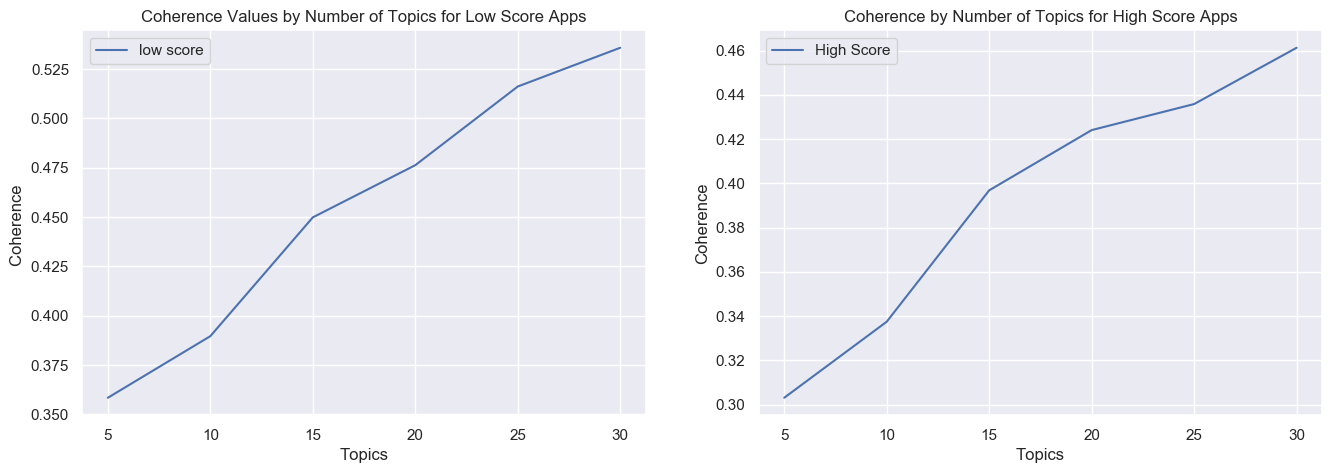

In [33]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import seaborn as sns; sns.set()

palette = dict(zip([1,2],sns.color_palette("nipy_spectral_r", 4)))

fig, (ax1, ax2)= plt.subplots(ncols = 2,figsize=(16, 5))
ax1 = sns.lineplot(topics ,low_coherence2017, palette = palette,ax=ax1, label = "low score")

ax1.set(xlabel ='Topics')
ax1.set(ylabel = 'Coherence ')
ax1.set_title('Coherence Values by Number of Topics for Low Score Apps')
leg =ax1.legend()
ax2 = sns.lineplot(topics, high_coherence2017, ax = ax2, label = "High Score")

ax2.set(xlabel ='Topics')
ax2.set(ylabel = 'Coherence')
ax2.set_title("Coherence by Number of Topics for High Score Apps")

plt.show()

In [34]:

highest_coherence_low_2017 = topics[low_coherence2017.index(max(low_coherence2017))]
highest_coherence_low_2017 
highest_coherence_high_2017 = topics[high_coherence2017.index(max(high_coherence2017))]
highest_coherence_high_2017 

30

In [35]:
mallet_low_2017 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low3, 
                                              num_topics=highest_coherence_low_2017,
                                              id2word=dic2017_low,
                                              workers = 4,random_seed = 2013)
    
mallet_high_2017 = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high3, 
                                              num_topics=highest_coherence_high_2017 ,
                                              id2word=dic2017_high, 
                                              workers = 4, random_seed = 2013)

In [36]:
for idx, topic in mallet_low_2017.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.320*"phone" + 0.066*"crash" + 0.049*"slow" + 0.046*"profil" + 0.046*"reinstal" + 0.040*"clear" + 0.032*"garbag" + 0.026*"advert" + 0.026*"freez" + 0.017*"storag" 

Topic: 1 
Words: 0.527*"batteri" + 0.125*"doctor" + 0.083*"saver" + 0.057*"life" + 0.024*"avail" + 0.015*"fake" + 0.012*"plug" + 0.009*"recent" + 0.006*"roll" + 0.006*"facebook" 

Topic: 2 
Words: 0.153*"option" + 0.112*"remov" + 0.059*"list" + 0.040*"mobil" + 0.034*"page" + 0.028*"wrong" + 0.028*"basic" + 0.028*"happi" + 0.025*"real" + 0.022*"newest" 

Topic: 3 
Words: 0.197*"instal" + 0.051*"reason" + 0.048*"email" + 0.041*"time" + 0.041*"viru" + 0.032*"danger" + 0.029*"mobil" + 0.029*"repli" + 0.025*"immedi" + 0.025*"mayb" 

Topic: 4 
Words: 0.160*"great" + 0.116*"longer" + 0.116*"function" + 0.078*"widget" + 0.034*"worth" + 0.034*"uninstal" + 0.027*"unlock" + 0.027*"design" + 0.020*"articl" + 0.020*"remov" 

Topic: 5 
Words: 0.153*"hate" + 0.149*"thing" + 0.075*"stupid" + 0.046*"code" + 0.043*"damn" + 

In [37]:
for idx, topic in mallet_high_2017.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.406*"awesom" + 0.102*"super" + 0.051*"love" + 0.042*"awsom" + 0.040*"superb" + 0.030*"word" + 0.027*"clariti" + 0.026*"simpli" + 0.025*"team" + 0.009*"helpful" 

Topic: 1 
Words: 0.338*"easi" + 0.108*"fast" + 0.107*"simpl" + 0.054*"user" + 0.037*"reliabl" + 0.037*"interfac" + 0.034*"clean" + 0.026*"effici" + 0.016*"smooth" + 0.013*"effect" 

Topic: 2 
Words: 0.129*"featur" + 0.074*"improv" + 0.070*"servic" + 0.055*"fantast" + 0.042*"contact" + 0.037*"support" + 0.031*"overal" + 0.024*"especi" + 0.024*"custom" + 0.020*"provid" 

Topic: 3 
Words: 0.442*"nice" + 0.195*"applic" + 0.061*"whatsapp" + 0.037*"enjoy" + 0.025*"good" + 0.016*"social_media" + 0.007*"display" + 0.006*"viber" + 0.006*"follow" + 0.005*"quicker" 

Topic: 4 
Words: 0.269*"app" + 0.052*"tri" + 0.044*"stop" + 0.040*"differ" + 0.031*"actual" + 0.030*"run" + 0.027*"optim" + 0.023*"power" + 0.023*"manag" + 0.022*"close" 

Topic: 5 
Words: 0.187*"email" + 0.069*"outlook" + 0.053*"mail" + 0.049*"account" + 

In [38]:
def topic_text(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [39]:
df_topic_sents_keywords_low = topic_text(ldamodel=mallet_low_2017, corpus=corpus_low3, texts=low3['text'])
df_dominant_topic_low = df_topic_sents_keywords_low.reset_index()
df_topic_text = df_dominant_topic_low.groupby(['Dominant_Topic', 'Perc_Contribution']).max()
print("Low score topics")
df_dominant_topic_low.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
sent_topics_sorteddf_mallet_low = pd.DataFrame()

sent_topics_outdf_grpd_low = df_topic_sents_keywords_low.groupby('Dominant_Topic')

Low score topics


In [28]:
for i, grp in sent_topics_outdf_grpd_low:
    sent_topics_sorteddf_mallet_low = pd.concat([sent_topics_sorteddf_mallet_low, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_low.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_low.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet_low

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1771,"phone, crash, slow, profil, reinstal, clear, g...","After signup by phone , set profile screen the..."
1,0.0,0.1753,"phone, crash, slow, profil, reinstal, clear, g...","After signup by phone , set profile screen the..."
2,0.0,0.1569,"phone, crash, slow, profil, reinstal, clear, g...","it keeps on crashing, It crashes continuously..."
3,0.0,0.1569,"phone, crash, slow, profil, reinstal, clear, g...","it keeps on crashing, It crashes continuously..."
4,0.0,0.1150,"phone, crash, slow, profil, reinstal, clear, g...",I don't know wth is up.. this is garbage. Lock...
5,1.0,0.1372,"batteri, doctor, saver, life, avail, fake, plu...",Another trash battery saver app. These must be...
6,1.0,0.1079,"batteri, doctor, saver, life, avail, fake, plu...",battery doctor Battery Doctor is a FREE batter...
7,1.0,0.0905,"batteri, doctor, saver, life, avail, fake, plu...",every battery doctor saver is fake.
8,1.0,0.0861,"batteri, doctor, saver, life, avail, fake, plu...",This seemed to have made my battery problem wo...
9,1.0,0.0845,"batteri, doctor, saver, life, avail, fake, plu...",The new update sucks. I used this app for 4 ye...


In [29]:
df_topic_sents_keywords_high = topic_text(ldamodel=mallet_high_2017, corpus=corpus_high3, texts=high3['text'])
df_dominant_topic_high = df_topic_sents_keywords_high.reset_index()
df_topic_text = df_dominant_topic_high.groupby(['Dominant_Topic', 'Perc_Contribution']).max()
print("high score topics")
df_dominant_topic_high.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
sent_topics_sorteddf_mallet_high = pd.DataFrame()

sent_topics_outdf_grpd_high = df_topic_sents_keywords_high.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_high:
    sent_topics_sorteddf_mallet_high = pd.concat([sent_topics_sorteddf_mallet_high, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)
sent_topics_sorteddf_mallet_high.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet_high.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet_high


high score topics


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1287,"awesom, super, love, awsom, superb, word, clar...",WWE Chant 'THIS IS AWESOME CLAP CLAP CLAP CLAP...
1,0.0,0.1029,"awesom, super, love, awsom, superb, word, clar...",Awesome awesome awesome awesome
2,0.0,0.0940,"awesom, super, love, awsom, superb, word, clar...",Wow I can't explain in words the quality and s...
3,0.0,0.0881,"awesom, super, love, awsom, superb, word, clar...",Super super super
4,0.0,0.0881,"awesom, super, love, awsom, superb, word, clar...",Super super super I liked it
5,1.0,0.2263,"easi, fast, simpl, user, reliabl, interfac, cl...","Hi users ,i think this app is good,maybe even ..."
6,1.0,0.2209,"easi, fast, simpl, user, reliabl, interfac, cl...","Hi users ,i think this app is good,maybe even ..."
7,1.0,0.1091,"easi, fast, simpl, user, reliabl, interfac, cl...",Easy to navigate and very clean user interface.
8,1.0,0.1008,"easi, fast, simpl, user, reliabl, interfac, cl...","It's fast, easy and has a clean interface."
9,1.0,0.0988,"easi, fast, simpl, user, reliabl, interfac, cl...",Clean and very easy User interface..


In [302]:
print(sent_topics_sorteddf_mallet_high['Text'][149])
year3[year3['text']==sent_topics_sorteddf_mallet_high['Text'][149] ]

When i m trying to set ok google detection by voice ... its saying " trouble connecting ... check ur connection nd try again ... i do it again n again bt its not working... i reinstall this app still not working


,appTitle,date,score,text,userName,datetime,year,review_length,processed
153134,Google Assistant,"December 7, 2017",5,When i m trying to set ok google detection by ...,Saurabh Priyadarshi,2017-12-07,2017,211,"[tri, googl, detect, voic, say, troubl, connec..."


|Topic|words|description|
|---|---|---|
Topic: 1| easi, fast, simpl, user, reliabl, interfac, clean, effici, smooth, effect|how apps are convenient easy to use, user interface is nice|
Topic: 2| featur, improv, servic, fantast, contact, support, overal, especi, custom, provid|what to imporve on | 
Topic: 3| app, tri, stop, differ, actual, run, optim, power, manag, close|functionality of battery app| 
Topic: 4| email, outlook, mail, account, access, sync, calendar, gmail, multipl, easili|microsoft outlook is great(general compliment)outlook is better than gmail |
Topic: 5| phone, charg, mobil, recommend, data, tool, tablet, perform, instal, wifi|great battery app (praising functions and how it helps the phone save battery, why its good)| 
Topic: 6| amazon, shop, love, conveni, experi, product, onlin, order, quick, price|amazon is great(best place to shop, why its great (good deals, good delivery, delivered in good condition)|
Topic: 7| googl, assist, person, home, siri, wait, question, repli, languag, answer|google assistant better than siri(new app needs some improvement)|
Topic: 8| friend, talk, famili, commun, text, school, member, smartphon, clearli, social_network|social networking apps and communication apps help connect people (in a good way)(connection with friends family)|
Topic: 9| chat, snapchat, great, video, filter, hangout, enjoy, funni, snap, group|snap chat (video quality) and general video calling compliments| 
Topic: 10| video, qualiti, call, sound, audio, vedio, high, visual, news, recept|video calling quality|
Topic: 11| updat, problem, work, samsung, day, check, latest, note, perfect, fix|need updates, fix problem|
Topic: 12| version, chang, option, open, turn, screen, notif, littl, miss, button|feature request in terms of version updates |
Topi: 13| remot, year, guy, control, user_friendli, lose, handi, smart, number, kid|great remote app| 
Topic: 14| download, music, play, free, song, definit, player, listen, add, total|music(google music), let it be free(compliments)| 
Topic: 15| work, great, perfect, issu, final, start, perfectli, replac, crazi, expect|two things mentioned (great productvity app for work such as outlook) or how the app functions properly or working properly| 
Topic: 16| thing, movi, watch, love, show, netflix, favorit, select, episod, season|video/movie/netflix (compliments)|
Topic: 17| batteri, save, life, saver, doctor, power, drain, longer, extend, hour|drains the battery instead of saving|
Topic: 18| voic, clear, abl, facebook, messeng, absolut, function, type, softwar, text|Google Assistant (Voice command reviews (neutral))|

|Topic|words|description|
|---|---|---|
Topic: 1| add, close, complet, love, terribl, sound, space, function, hate, correctli |ads (complaints)|
Topic: 2| messag, number, send, peopl, account, video, group, chat, die, block|instant messaging (ICQ bad)| 
Topic: 3| phone, slow, pop, caus, clear, leav, unus, till, earlier, suddenli|apps cause slow/freeze (battery apps)|
Topic: 4| stop, delet, doctor, profil, shut, improv, process, forc, freez, month|lagging complaints (battery apps)|
Topic: 5| updat, hate, latest, ugli, requir, find, volum, kitkat, set, stop|complaints towards battery app draining battery| 
Topic: 6| batteri, drain, faster, fast, program, monitor, watch, eat, devic, live|Drains Battery!|
Topic: 7| batteri, saver, doctor, increas, audio, crazi, excel, qualiti, classic, capac|baterry app doesnt help| 
Topic: 8| option, remov, function, set, phone, garbag, aw, stuff, past, current|not saving battery|
Topic: 9| data, minut, issu, info, click, android, nice, provid, releas, week|collects data/data usage|
Topic: 10| chang, widget, user, recent, long, lose, interfac, sorri, extrem, design|widget/ design| 
Topic: 11| list, develop, star, crash, rat, access, give, viru, googl, contact|Crashing/Virus|
Topic: 12| notif, year, annoy, worst, intrus, constantli, fail, pretti, day, joke|notifications/ads|
Topic: 13| batteri, save, open, life, mode, real, restart, creat, edit, reduc|battery not saved hate ads| 
Topic: 14| updat, latest, worst, reason, connect, worth, call, star, compani, rubbish|Updates needed (complaints)|
Topic: 15| updat, suck, check, internet_connect, fix, feel, sign, overheat, year, lag|Updates needed(internet, lagging overheating)|
Topic: 16| charg, start, hour, make, trickl, wors, reinstal, fulli, plu, sleep|Complaints(Battery apps not working)|
Topic: 17| screen, turn, lock, usag, set, tablet, absolut, immedi, display, cheetah|Screen problems(Lock screen problem, notifications and ads) (Peel Remote)| 
Topic: 18| time, wast, damn, wait, wifi, forev, altern, link, instruct, easi|waste of time(complaints)|
Topic: 19| show, problem, tri, mobil, wrong, statu, inform, horribl, perform, articl|Problems|
Topic: 20| version, previou, upgrad, revert, warn, older, style, purchas, view, sign|Upgrade the app|
Topic: 21| app, run, background, kill, advert, claim, consum, person, detect, suggest|complaints(advertisements in the background etc.)|
Topic: 22| download, dont, fake, firmwar, secur, softwar, hard, clean_master, coupl, file|battey app problems (fake doesnt work like it should etc)|
Topic: 23| featur, search, samsung, load, galaxi, happen, hour, menu, worthless, longer|Samgsung problems|